# 权重衰减
上⼀节中我们观察了过拟合现象，即模型的训练误差远小于它在测试集上的误差。虽然增⼤训练
数据集可能会减轻过拟合，但是获取额外的训练数据往往代价⾼昂。本节介绍应对过拟合问题的
常⽤⽅法：权重衰减（weight decay）。
### ⽅法
权重衰减等价于$L_2$范数正则化（regularization）。正则化通过为模型损失函数添加惩罚项使学出
的模型参数值较小，是应对过拟合的常⽤⼿段。我们先描述$L_2$范数正则化，再解释它为何⼜称权
重衰减。
$L_2$范数正则化在模型原损失函数基础上添加L2范数惩罚项，从而得到训练所需要最小化的函数。
$L_2$范数惩罚项指的是模型权重参数每个元素的平⽅和与⼀个正的常数的乘积。以[“线性回归”](3.1linear-regression.ipynb)⼀
节中的线性回归损失函数

$$\ell(w_1, w_2, b) = \frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right)^2$$

为例，其中$w_1, w_2$是权重参数，$b$是偏差参数，样本$i$的输⼊为$x^{(i)}_1, x^{(i)}_2 ，标签为y^{(i)}，样本数为n$。将
权重参数⽤向量$w = [w1, w2]$表⽰，带有$L_2$范数惩罚项的新损失函数为

$$\ell(w_1, w_2, b) + \frac \lambda {2n} \lVert w \rVert^2 $$

其中超参数$λ > 0$。当权重参数均为0时，惩罚项最小。当$λ$较⼤时，惩罚项在损失函数中的⽐重较
⼤，这通常会使学到的权重参数的元素较接近0。当$λ$设为0时，惩罚项完全不起作⽤。上式中$L_2$范
数平⽅$\lVert w \rVert^2$展开后得到$w_1^2 + w^2_2$。有了$L_2$范数惩罚项后，在小批量随机梯度下降中，我们将[“线
性回归”](3.1linear-regression.ipynb)⼀节中权重$w_1和w_2$的迭代⽅式更改为

$
    \begin{aligned}
    w_1 &\leftarrow (1-\frac{\eta \lambda}{|\mathcal{B}|})w_1 - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \frac{ \partial \ell^{(i)}(w_1, w_2, b)  }{\partial w_1},\\
    w_2 &\leftarrow (1-\frac{\eta \lambda}{|\mathcal{B}|})w_2 - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \frac{ \partial \ell^{(i)}(w_1, w_2, b)  }{\partial w_2}\\
    \end{aligned}
$

可⻅，$L_2$范数正则化令权重$w_1和w_2$先⾃乘小于1的数，再减去不含惩罚项的梯度。因此，$L_2$范数
正则化⼜叫权重衰减。权重衰减通过惩罚绝对值较⼤的模型参数为需要学习的模型增加了限制，
这可能对过拟合有效。实际场景中，我们有时也在惩罚项中添加偏差元素的平⽅和。
## ⾼维线性回归实验
下⾯，我们以⾼维线性回归为例来引⼊⼀个过拟合问题，并使⽤权重衰减来应对过拟合。设数据
样本特征的维度为$p。对于训练数据集和测试数据集中特征为x_1, x_2, . . . , x_p$的任⼀样本，我们使⽤
如下的线性函数来⽣成该样本的标签：

$$y=0.05+\sum_{i=1}^n0.01x_i+\epsilon, $$

其中噪声项ϵ服从均值为0、标准差为0.01的正态分布。为了较容易地观察过拟合，我们考虑⾼维
线性回归问题，如设维度p = 200；同时，我们特意把训练数据集的样本数设低，如20。

In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = nd.ones((num_inputs,1))*0.01, 0.05

features = nd.random.normal(scale=0.01,shape=(n_train+n_test,num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train,:], features[n_train:,:]
train_labels, test_labels = labels[:n_train], labels[n_train:]

## 从零开始实现
下⾯先介绍从零开始实现权重衰减的⽅法。我们通过在⽬标函数后添加$L_2$范数惩罚项来实现权
重衰减
### 初始化模型参数
⾸先，定义随机初始化模型参数的函数。该函数为每个参数都附上梯度。

In [6]:
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    w.attach_grad()
    b.attach_grad()
    return [w, b]

### 定义$L_2$范数惩罚项
下⾯定义$L_2$范数惩罚项。这⾥只惩罚模型的权重参数。

In [8]:
def l2_penalty(w):
    return (w**2).sum()/2

### 定义训练和测试
下⾯定义如何在训练数据集和测试数据集上分别训练和测试模型。与前⾯⼏节中不同的是，这⾥
在计算最终的损失函数时添加了L2范数惩罚项。

In [4]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss
train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features,train_labels),
                             batch_size,shuffle=True)
def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
            # 添加了L2范数惩罚项
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b),train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b),test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
        range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().asscalar())

### 观察过拟合
接下来，让我们训练并测试⾼维线性回归模型。当lambd设为0时，我们没有使⽤权重衰减。结
果训练误差远小于测试集上的误差。这是典型的过拟合现象。

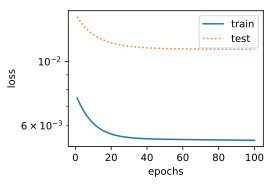

L2 norm of w: 13.294222


In [9]:
fit_and_plot(lambd=0)

### 使⽤权重衰减
下⾯我们使⽤权重衰减。可以看出，训练误差虽然有所提⾼，但测试集上的误差有所下降。过拟
合现象得到⼀定程度的缓解。另外，权重参数的$L_2$范数⽐不使⽤权重衰减时的更小，此时的权重
参数更接近0

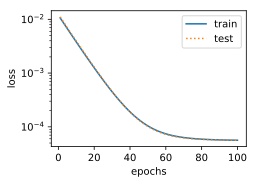

L2 norm of w: 0.035642713


In [19]:
fit_and_plot(lambd=3)

## 简洁实现
这⾥我们直接在构造Trainer实例时通过wd参数来指定权重衰减超参数。默认下， Gluon会对权
重和偏差同时衰减。我们可以分别对权重和偏差构造Trainer实例，从而只对权重衰减

In [12]:
def fit_and_plot_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    # 对权重参数衰减。权重名称⼀般是以weight结尾
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd',{'learning_rate': lr, 'wd': wd})
    # 不对偏差参数衰减。偏差名称⼀般是以bias结尾
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',{'learning_rate': lr})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            # 对两个Trainer实例分别调⽤step函数，从⽽分别更新权重和偏差
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(loss(net(train_features),train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())

与从零开始实现权重衰减的实验现象类似，使⽤权重衰减可以在⼀定程度上缓解过拟合问题。

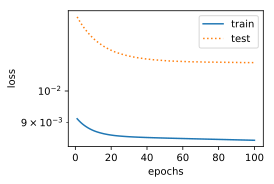

L2 norm of w: 14.214939


In [13]:
fit_and_plot_gluon(0)

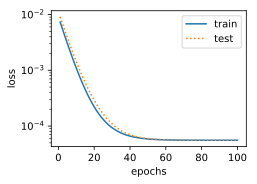

L2 norm of w: 0.00020069325


In [17]:
fit_and_plot_gluon(3)

## 小结
- 正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常⽤⼿段。
- 权重衰减等价于$L_2$范数正则化，通常会使学到的权重参数的元素较接近0。
- 权重衰减可以通过Gluon的wd超参数来指定。
- 可以定义多个Trainer实例对不同的模型参数使⽤不同的迭代⽅法。